In [107]:
#importing packages
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow as tf, tensorflow_datasets as tfds, matplotlib.pyplot as plt, numpy as np, pandas as pd

In [108]:
#loading dataset
(train_ds, test_ds, validate_ds), ds_info = tfds.load('beans', split=['train','test','validation'], with_info=True, 
                                           as_supervised=True)#this returns image, label tuple

#printing shape
print(f'Training Set - {train_ds}')
print(f'Validation Set - {validate_ds}')
print(f'Test Set - {test_ds}')

Training Set - <PrefetchDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>
Validation Set - <PrefetchDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>
Test Set - <PrefetchDataset shapes: ((500, 500, 3), ()), types: (tf.uint8, tf.int64)>


In [109]:
#class values
class_dict ={0: 'Angular Leaf Spot',
            1: 'Bean Rust',
            2: 'Healthy'}

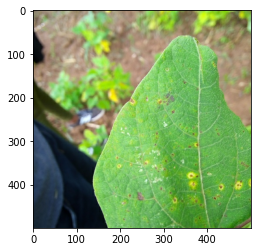

Bean Rust


In [110]:
#sample record
for example in train_ds.take(1):
    
    #displaying image and class label
    plt.figure()
    plt.imshow(example[0].numpy())
    plt.show()
    print(f"{class_dict[example[1].numpy()]}")

In [111]:
#function to normalize image
#converting from unit8 to float32
def normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img,(100,100))
    return img, label


train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validate_ds = validate_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [112]:
#pipeline
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(ds_info.splits['train'].num_examples)
train_ds = train_ds.batch(40)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

test_ds = test_ds.cache()
test_ds = test_ds.shuffle(ds_info.splits['test'].num_examples)
test_ds = test_ds.batch(40)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

validate_ds = validate_ds.cache()
validate_ds = validate_ds.shuffle(ds_info.splits['validation'].num_examples)
validate_ds = validate_ds.batch(40)
validate_ds = validate_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [113]:
#creating network
#using ResNet50 as base layer

resnet = ResNet50(include_top=False, #loading without classification layer
                 input_tensor=layers.Input(shape=(100,100,3)))

model = keras.Sequential([
    resnet, #pretrained model,
    layers.Flatten(), #converting model output to 1D array
    layers.Dense(units=15, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(units=3, activation='sigmoid'), #classification layers with units same as num classes
    layers.Softmax()
])

In [114]:
#compiling model
model.compile(optimizer='adam',
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),#use this when labels are integers,
             metrics=['accuracy'])

#early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=15, min_delta=0.001, restore_best_weights=True)

In [115]:
print(train_ds)
#training model
history = model.fit(
    train_ds,
    validation_data=(validate_ds),
    epochs=100,
    callbacks = [early_stopping]
)

<PrefetchDataset shapes: ((None, 100, 100, 3), (None,)), types: (tf.float32, tf.int64)>
Epoch 1/100
26/26 [==============================] - 11s 411ms/step - loss: 1.0292 - accuracy: 0.5619 - val_loss: 1.1139 - val_accuracy: 0.3383
Epoch 2/100
26/26 [==============================] - 4s 168ms/step - loss: 0.9783 - accuracy: 0.6838 - val_loss: 1.1045 - val_accuracy: 0.3383
Epoch 3/100
26/26 [==============================] - 4s 163ms/step - loss: 0.9932 - accuracy: 0.6393 - val_loss: 1.1139 - val_accuracy: 0.3383
Epoch 4/100
26/26 [==============================] - 4s 163ms/step - loss: 0.9767 - accuracy: 0.6896 - val_loss: 1.1068 - val_accuracy: 0.3308
Epoch 5/100
26/26 [==============================] - 4s 163ms/step - loss: 0.9790 - accuracy: 0.6799 - val_loss: 1.1139 - val_accuracy: 0.3383
Epoch 6/100
26/26 [==============================] - 4s 164ms/step - loss: 0.9682 - accuracy: 0.7147 - val_loss: 1.1148 - val_accuracy: 0.3383
Epoch 7/100
26/26 [==============================] - 

26/26 [==============================] - 4s 170ms/step - loss: 0.9079 - accuracy: 0.9004 - val_loss: 0.9292 - val_accuracy: 0.8421
Epoch 58/100
26/26 [==============================] - 4s 166ms/step - loss: 0.9066 - accuracy: 0.9072 - val_loss: 0.9726 - val_accuracy: 0.7068
Epoch 59/100
26/26 [==============================] - 4s 168ms/step - loss: 0.9007 - accuracy: 0.9217 - val_loss: 0.9207 - val_accuracy: 0.8722
Epoch 60/100
26/26 [==============================] - 4s 172ms/step - loss: 0.9041 - accuracy: 0.9159 - val_loss: 0.9089 - val_accuracy: 0.8947
Epoch 61/100
26/26 [==============================] - 4s 165ms/step - loss: 0.9036 - accuracy: 0.9168 - val_loss: 0.9767 - val_accuracy: 0.6842
Epoch 62/100
26/26 [==============================] - 4s 166ms/step - loss: 0.9208 - accuracy: 0.8675 - val_loss: 1.0371 - val_accuracy: 0.5714
Epoch 63/100
26/26 [==============================] - 4s 167ms/step - loss: 0.9027 - accuracy: 0.9207 - val_loss: 1.0260 - val_accuracy: 0.6015
Epoch

Minimum validation loss: 0.9089406728744507


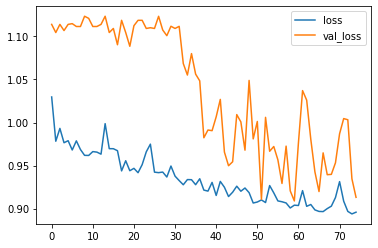

In [116]:
#learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [117]:
#model performance
model.evaluate(test_ds,verbose=2)

[0.9832538217306137, 0.78125]